In [40]:
from function import count_most_used_char
import pandas as pd

In [41]:
df = pd.read_csv("./alpha_beta.csv")
len(df)

2541

In [42]:
import time
from functools import wraps
import statistics

def time_function(times: int = 1, verbose: bool = False):
    def decorate(fn):
        @wraps(fn)
        def inner():
            tic = time.perf_counter()
            for _ in range(times):
                fn()
            toc = time.perf_counter()
            
            full = toc - tic
            if verbose:
                print(f"Function took {full:0.4f} seconds")
            return toc - tic
    
        return inner
    return decorate


def time_average(times: int = 1, verbose: bool = False):
    def decorate(fn):
        @wraps(fn)
        def inner():
            got_times = []
            for _ in range(times):
                got_times.append(fn())
            
            avg = round(sum(got_times) / len(got_times), 6)
            sigma = round(statistics.stdev(got_times), 6)
            if verbose:
                print(f"Time μ = {avg}, σ = {sigma}")
            return avg, sigma
        return inner
    return decorate

times_save = {}

In [43]:
@time_average(5, verbose=True)
@time_function(10)
def hello():
    time.sleep(0.01)
    
hello()

Time μ = 0.101222, σ = 0.000134


(0.101222, 0.000134)

In [44]:
@time_average(5, verbose=True)
@time_function(10)
def unoptimized():
    count = []
    for seq in df.Sequence:
        c = count_most_used_char(seq)
        count.append(c)
            
unoptimized_time, unoptimized_err = unoptimized()
times_save["unoptimized_time"] = (unoptimized_time, unoptimized_err)
times_save["unoptimized_time"]

Time μ = 4.369557, σ = 0.031268


(4.369557, 0.031268)

In [45]:
@time_average(5, verbose=True)
@time_function(10)
def using_map():
    count = list(map(count_most_used_char, df.Sequence))
        
using_map_time, using_map_err = using_map()
times_save["using_map_time"] = (using_map_time, using_map_err)
times_save["using_map_time"]

Time μ = 4.400349, σ = 0.016364


(4.400349, 0.016364)

In [46]:
import multiprocessing.dummy

@time_average(5, verbose=True)
@time_function(10)
def using_proc_map():
    p = multiprocessing.dummy.Pool(8)
    count = list(p.map(count_most_used_char, df.Sequence))
    
using_proc_map_time, using_proc_map_err = using_proc_map()
times_save["using_proc_map_time"] = (using_proc_map_time, using_proc_map_err)
times_save["using_proc_map_time"]

Time μ = 4.346289, σ = 0.031651


(4.346289, 0.031651)

In [47]:
import threading

def thread_target(start, end):
    return list(map(count_most_used_char, df.Sequence.iloc[start:end]))
 
@time_average(5, verbose=True)
@time_function(10)
def using_threads():
    n = len(df.Sequence)
    i = n // 4
    
    start = 0
    end = i
    
    threads = []
    
    for thread in range(4):                
        start += i
        end += i
        
        x = threading.Thread(target=thread_target, args=(start, end,))
        threads.append(x)
        x.start()
        
    for thread in threads:
        thread.join()

        
    return i

using_threads_time, using_threads_err = using_threads()
times_save["using_threads_time"] = (using_threads_time, using_threads_err)
times_save["using_threads_time"]

Time μ = 3.273155, σ = 0.009837


(3.273155, 0.009837)

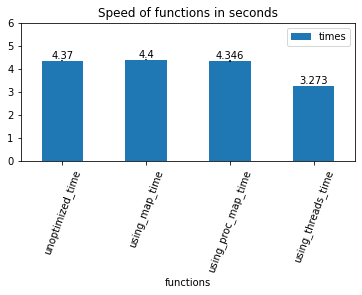

In [54]:
times_df = pd.DataFrame(
    {
        "functions": times_save.keys(),
        "times": [round(x[0], 3) for x in times_save.values()],
        "err": [x[1] for x in times_save.values()],
    }
)

import matplotlib.pyplot as plt

def add_labels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha="center", va="bottom")

times_df.plot.bar(x="functions", y="times", yerr="err", rot=70, title="Speed of functions in seconds");
add_labels(list(times_df["functions"]), list(times_df["times"]))
plt.ylim(0, 6)
plt.subplots_adjust(bottom=0.4)

plt.savefig("out.png", facecolor="#fff")
plt.show();